In [101]:
import pandas as pd
import numpy as np
import catboost as cb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder
import pprint
from  time import time
import fancyimpute as fi
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [60]:
train_df = pd.DataFrame.from_csv('train.csv')
test_df = pd.DataFrame.from_csv('test.csv')

In [98]:
# Encoding Labels
n_train = train_df.copy()
n_train['Gender'].replace({'Male':1,'Female':0},inplace = True)
n_train['Married'].replace({'Yes':1,'No':0},inplace = True)
n_train['Education'].replace({'Graduate':1,'Not Graduate':0},inplace = True)
n_train['Self_Employed'].replace({'Yes':1,'No':0},inplace = True)
n_train['Property_Area'].replace({'Semiurban':1,'Urban':0,'Rural':2},inplace = True)
n_train['Dependents'].replace({'0':0,'1':1,'2':2,'3+':3},inplace = True)


In [105]:
n_train = n_train.drop(['Loan_Status'],axis = 1)

In [106]:
# Using MICE package to fill up missing values

df=pd.DataFrame(data=fi.KNN(k=3).fit_transform(n_train), columns=n_train.columns, index=n_train.index)

Imputing row 1/614 with 1 missing, elapsed time: 0.094
Imputing row 101/614 with 0 missing, elapsed time: 0.094
Imputing row 201/614 with 0 missing, elapsed time: 0.094
Imputing row 301/614 with 0 missing, elapsed time: 0.094
Imputing row 401/614 with 0 missing, elapsed time: 0.094
Imputing row 501/614 with 0 missing, elapsed time: 0.094
Imputing row 601/614 with 2 missing, elapsed time: 0.094


In [109]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001002,1.0,0.0,0.0,1.0,0.0,5849.0,0.0,139.237672,360.0,1.0,0.0
LP001003,1.0,1.0,1.0,1.0,0.0,4583.0,1508.0,128.000000,360.0,1.0,2.0
LP001005,1.0,1.0,0.0,1.0,1.0,3000.0,0.0,66.000000,360.0,1.0,0.0
LP001006,1.0,1.0,0.0,0.0,0.0,2583.0,2358.0,120.000000,360.0,1.0,0.0
LP001008,1.0,0.0,0.0,1.0,0.0,6000.0,0.0,141.000000,360.0,1.0,0.0


In [56]:

mode_columns = ['Self_Employed','Dependents','Loan_Amount_Term','Gender','Married']
median_cols = ['LoanAmount']

for i in mode_columns:
    train_df[i] = train_df[i].fillna(train_df[i].mode()[0])

train_df['LoanAmount'] = train_df['LoanAmount'].fillna(train_df['LoanAmount'].median())

train_df['Credit_History'] = train_df['Credit_History'].fillna(2)

In [57]:
for i in mode_columns:
    test_df[i] = test_df[i].fillna(test_df[i].mode()[0])

test_df['LoanAmount'] = test_df['LoanAmount'].fillna(test_df['LoanAmount'].median())

In [121]:
# train_df['Loan_Status'] = np.where(train_df['Loan_Status'] == 'Y',1,0)
# X = train_df.drop(['Loan_Status'],axis =1)
y = pd.DataFrame(train_df['Loan_Status'])
X = df



In [59]:
train_df.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status            int32
dtype: object

In [110]:
categorical_features_indices = [0,1,2,3,4,8,9,10]

In [111]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)

    return best_params

In [112]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [113]:
# Initializing a CatBoostClassifier
clf = cb.CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',cat_features=categorical_features_indices,                        
                         verbose = False)

In [114]:
# Defining your search space
search_spaces = {'iterations': Integer(400,800),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.05,2),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Integer(1,10)}

# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring='roc_auc',
                    cv= 5,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,                    
                    random_state=42)



In [115]:
# Running the optimization
time_limit = 10 # in minutes
best_params = report_perf(opt, X, y,'CatBoost',
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*time_limit)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 194.0834
Function value obtained: -0.7347
Current minimum: -0.7347
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 78.8138
Function value obtained: -0.7269
Current minimum: -0.7347
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 44.5601
Function value obtained: -0.7111
Current minimum: -0.7347
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 138.6894
Function value obtained: -0.7259
Current minimum: -0.7347
Iteration No: 5 started. Searching for the next optimal point.
CatBoost took 491.16 seconds,  candidates checked: 4, best CV score: 0.735 ± 0.041
Best parameters:
{'b

In [122]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [123]:
clf = cb.CatBoostClassifier(thread_count=2,
                            bagging_temperature = 0.41010395885331385,
                            border_count = 186,
                            depth =8,
                            iterations = 526,
                            l2_leaf_reg = 21,
                            learning_rate = 0.8575313333468001,
                            random_strength = 3.230824361824754e-06,
                            scale_pos_weight = 8,
                         loss_function='Logloss',cat_features=categorical_features_indices,                        
                         verbose = False)
clf.fit(X_train,y_train)

CatboostError: Invalid type for cat_feature[21,0]=0.9999999711812771 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [69]:
clf.score(X_train,y_train)

0.9103869653767821

In [70]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [45]:
clf.feature_importances_

array([ 0.91848356,  0.61164228,  6.1918305 ,  1.73943307,  0.24054603,
       19.44414342,  9.19789436, 19.17713519,  3.26533389, 29.53940405,
        9.67415366])

In [71]:
clf.score(X_test,y_test)

0.7967479674796748

In [72]:
sub_df = pd.DataFrame()
sub_df['Loan_ID'] = test_df.index
sub_df['Loan_Status'] = clf.predict(test_df)


In [74]:
sub_df['Loan_Status'] = np.where(sub_df['Loan_Status']==1,'Y','N')

In [75]:
sub_df.to_csv('sub1.csv',index = False)

In [44]:
# Data Exploration

train_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [47]:
train_df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

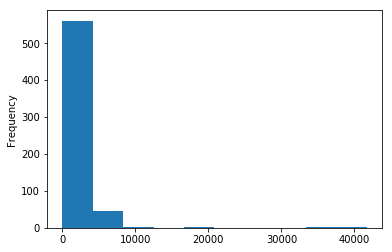

In [51]:
train_df['CoapplicantIncome'].plot.hist()

In [61]:
train_df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64